###  Linus Tech Tips Forum Cinebench Ergebnisse (Max Hammer, 5.12.2021)

#### Project Summary
1.1. Perform EDA for the provided data

a. Perform EDA

1.2. Linear regression

a. Define linear function for your analysis. That is, f=ai+b, where a is the slope and b is the intercept. So find the best fit line using np.polyfit().

b. Plot the data and the best fit line. Print out the slope and intercept. (Think: what are their units?)

1.3. How is it optimal?

a. The function np.polyfit() that you used to get your regression parameters finds the optimal slope and intercept. It is optimizing the sum of the squares of the residuals, also known as RSS (for residual sum of squares). Plot the function that is being optimized, the RSS, versus the slope parameter a. To do this, fix the intercept to be what you found in the optimization. Then, plot the RSS vs. the slope. Where is it minimal? What does it mean for the research?

1.4. Pairs bootstrap or permutation?

a. Perform pairs bootstrap or permutation to plot a histogram describing the estimate of the slope from the data. Also report the 95% confidence interval of the slope.

1.5. Plotting bootstrap or permutation regressions

a. A nice way to visualize the variability we might expect in a linear regression is to plot the line you would get from each replicate of the slope and intercept. Do this for the first 100 of your replicates of the slope and intercept

1.6. Hypothesis test on Pearson correlation

a. Formulate Hypothesis and Test it. Provide a conclusion for it

1.7. Provide the conclusion of your clock speed research. Is it possible to perfume here A/B Test? What it can show? What confidence intervals and p-values show us in regard to testing of Null-hypothesis?

1.8. What shows us a Bonferroni test? Use: https://www.investopedia.com/terms/b/bonferroni-test.asp

In [91]:
# Do all imports and installs here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
import re
import datetime
from scipy import optimize
from matplotlib.lines import Line2D

### Step 1: Scope the Project and Gather Data

#### Describe and Gather Data 
First dataset are the results of the Linus Tech Tips forum cinebench results, gathered from https://linustechtips.com/topic/62476-post-your-cinebench-r2015r1152003-scores-dont-read-the-op-plz/

Second dataset is the cpu db from techpowerup (https://www.techpowerup.com/cpu-specs/)

In [92]:
# Read in the data here
multithread_data = pd.read_csv("Linus tech tips Cinebench R15 scores - CPU muti thread.csv")

cpu_data = pd.read_csv("cpus.csv")

In [93]:
# remove unnecessary columns
multithread_data = multithread_data.drop(["Name", "extra info"], axis=1)
cpu_data = cpu_data.drop("Unnamed: 0", axis=1)

In [94]:
# map the names from the ltt forum to the name format from techpowerup
def map_intel_name(name):
  template = "Core {}-{}"
  split = name.split(' ')
  return template.format(split[2].lower(), split[3])

def multiprocessor_remove(name):
  return name.split('x ')[1]

def remove_amd(name):
  return name.split('AMD ')[1]

def remove_intel(name):
  return name.split('Intel ')[1]

def format_epy(name):
  return "EPYC {}".format(name.split('Epyc ')[1])

def map_name(name):
  intel_core = re.compile('Intel Core I\d')
  multiprocessor = re.compile('^\dx')
  amd = re.compile('^AMD')
  intel = re.compile('^Intel')
  epys = re.compile('^Epyc')
  if intel_core.match(name):
    return map_intel_name(name)
  if multiprocessor.match(name):
    name = multiprocessor_remove(name)
  if amd.match(name):
    name = remove_amd(name)
  if intel.match(name):
    name = remove_intel(name)
  return name

print(map_name("Intel Core I9 9900K"))
print(map_name("Ryzen Threadripper 1950X"))

multithread_data['CPU'] = multithread_data['CPU'].map(map_name)

print(multithread_data)

Core i9-9900K
Ryzen Threadripper 1950X
      Position                 CPU Clock Speed  Score (cb)
0            1  Xeon Platinum 8168     3.49ghz        8205
1            2           Epyc 7601      2.2ghz        6873
2            3        Xeon 8357 V3      2.5ghz        6139
3            4  Xeon Platinum 8168      2.7ghz        5926
4            5     Xeon E5 2696 V4      2.2ghz        5713
...        ...                 ...         ...         ...
1500      1502             A6 1450        1ghz          35
1501      1503               E-300      1.3ghz          31
1502      1504       Sempron 3000+    1.795ghz          23
1503      1505           Atom N450    1.667ghz          22
1504      1506                C-50    1.013ghz          20

[1505 rows x 4 columns]


In [95]:
# Sanitize clocks on cou base stats
def remove_MHz(clk):
  num = pd.to_numeric(clk.split(' MHz')[0])
  return num / 1000

def remove_GHz(clk):
  return pd.to_numeric(clk.split('GHz')[0])

def map_clk_speed(clk):
  mhz_regex = re.compile('^\d{3,} MHz$')
  if mhz_regex.match(clk):
    return remove_MHz(clk)
  return remove_GHz(clk)

cpu_data['minclock'] = cpu_data['minclock'].map(map_clk_speed)
cpu_data['maxclock'] = cpu_data['maxclock'].map(map_clk_speed)

cpu_data['cores'] = pd.to_numeric(cpu_data['cores'])
cpu_data['threads'] = pd.to_numeric(cpu_data['threads'])

In [96]:
# Remove ghz from clock speed on ltt dataset
def remove_ghz(clk):
  return clk.split('ghz')[0]

multithread_data['Clock Speed'] = pd.to_numeric(multithread_data['Clock Speed'].map(remove_ghz))

In [97]:
# extract only year from release date
def extract_year(date):
  split = date.split(' ')
  return pd.to_numeric(split[-1])

cpu_data['release'] = cpu_data['release'].map(extract_year)

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chosen that model

#### 3.2 Hypothesis Tests
provide needed statistiks with explonation and answer to your business questions for the analysis

In [98]:
# Create Overclock Dataset
overclock_data = pd.DataFrame()

for idx,row in multithread_data.iterrows():
  base_entry = cpu_data[cpu_data['name'] == row['CPU']]
  if base_entry.empty:
    continue
  new_entry = {'cpu':row['CPU'], 'cores':base_entry['cores'].values[0],'threads':base_entry['threads'].values[0], 'base_clk':base_entry['minclock'].values[0], 'boost_clk':base_entry['maxclock'].values[0], 'oc_clk':row['Clock Speed'], 'release':base_entry['release'].values[0]}
  
  if idx == 0:
    overclock_data = pd.DataFrame.from_dict(new_entry)
  else:
    overclock_data = overclock_data.append(new_entry, ignore_index=True)

overclock_data = overclock_data.assign(oc_diff=lambda x: x['oc_clk'] - x['base_clk'])
overclock_data = overclock_data.assign(oc_boost_diff=lambda x: x['oc_clk'] - x['boost_clk'])
overclock_data = overclock_data.sort_values(by=["release"])
overclock_data.head()


,cpu,cores,threads,base_clk,boost_clk,oc_clk,release,oc_diff,oc_boost_diff
1049,Sempron 3000+,1.0,1.0,1.8,1.8,1.795,2001.0,-0.005,-0.005
1046,Athlon 64 3500+,1.0,1.0,2.2,2.2,2.200,2001.0,0.000,0.000
1045,Athlon 64 3700+,1.0,1.0,2.2,2.2,2.200,2001.0,0.000,0.000
1038,Athlon 64 FX-57,1.0,1.0,2.8,2.8,3.080,2005.0,0.280,0.280
1030,Athlon 64 X2 3800+,2.0,2.0,2.0,2.0,2.550,2005.0,0.550,0.550


# Description of the dataset

cpu: name of the processor<br>
cores: the amount of physical cores the cpu has<br>
threads: the amount of logical threads a cpu has (usually cores*2)<br>
base_clk: the base clock speed of the cpu as specified by the manufacturer<br>
boost_clk: the maximum boost clock speed of the cpu as specified by the manufacturer<br>
oc_clk: the achieved overclocked clock speeds of the cpu<br>
release: the year in which the cpu was released<br>
oc_diff: oc_clk - base_clk<br>
oc_boost_diff: oc_clk - boost_clk<br>

In [99]:
# Perform EDA
mean_oc_diff = np.mean(overclock_data.oc_diff)
median_oc_diff = np.mean(overclock_data.oc_diff)
std_dev_oc_diff = np.std(overclock_data.oc_diff)

mean_oc_boost_diff = np.mean(overclock_data.oc_boost_diff)
median_oc_boost_diff = np.mean(overclock_data.oc_boost_diff)
std_dev_oc_boost_diff = np.std(overclock_data.oc_boost_diff)

print('Mean of oc clock difference to base clock: {}GHz'.format(mean_oc_diff))
print('Median of oc clock difference to base clock: {}GHz'.format(median_oc_diff))
print('Standard deviation oc vs base clock difference: ', std_dev_oc_diff)

print('Mean of oc clock difference to boost clock: {}GHz'.format(mean_oc_boost_diff))
print('Median of oc clock difference to boost clock: {}GHz'.format(median_oc_boost_diff))
print('Standard deviation oc vs boost clock difference: ', std_dev_oc_boost_diff)

Mean of oc clock difference to base clock: 0.9476444866920153GHz
Median of oc clock difference to base clock: 0.9476444866920153GHz
Standard deviation oc vs base clock difference:  0.6261307376311162
Mean of oc clock difference to boost clock: 0.5594743346007605GHz
Median of oc clock difference to boost clock: 0.5594743346007605GHz
Standard deviation oc vs boost clock difference:  0.6941850806142199


In [100]:
# Show outliers
print('Outliers_min',overclock_data.oc_diff.min())
print('Outliers_max',overclock_data.oc_diff.max())

print('Outliers_min_boost',overclock_data.oc_boost_diff.min())
print('Outliers_max_boost',overclock_data.oc_boost_diff.max())



Outliers_min -0.2959999999999998
Outliers_max 2.777
Outliers_min_boost -1.6
Outliers_max_boost 2.6900000000000004


### Step 4: Show your solution: the Model of  Data and any conclutions 
#### 4.1 Create graphics, any needed queris to visualise your solution


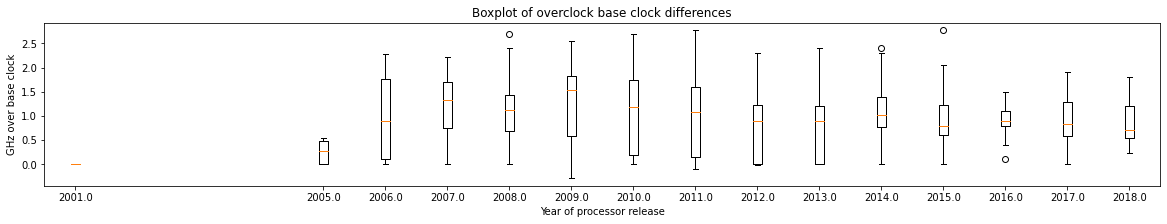

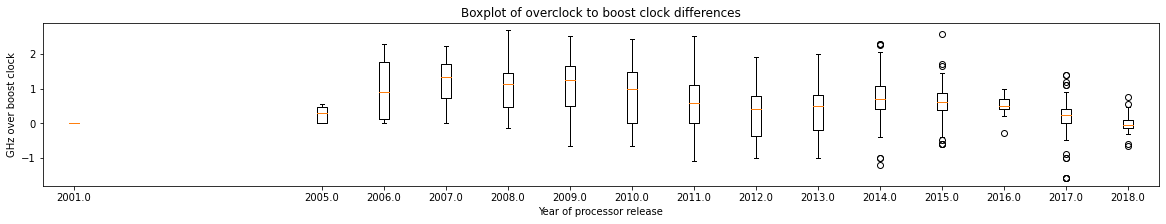

In [101]:
# Boxplot per year oc results
release_years = overclock_data['release'].unique()
release_years.sort()

plt.figure(figsize=(20,3))
plt.title('Boxplot of overclock base clock differences')
for year in release_years:
  plt.boxplot(overclock_data[overclock_data['release'] == year]['oc_diff'], positions=[year])
plt.ylabel('GHz over base clock')
plt.xlabel('Year of processor release')
plt.show()

plt.figure(figsize=(20,3))
plt.title('Boxplot of overclock to boost clock differences')
for year in release_years:
  plt.boxplot(overclock_data[overclock_data['release'] == year]['oc_boost_diff'], positions=[year])
plt.ylabel('GHz over boost clock')
plt.xlabel('Year of processor release')
plt.show()

# Result interpretation
The difference in outliers, when comparing the plots for base clock and boost clock, is mainly due to the nature of Intel's boost especially on many core processors. 

As an example the i9-9900K:
  Intel advertises a boost clock ofa 5GHz, but only for a load of up to 2 cores.<br>
  For any load of up to 4 cores, the processor's boost clock is lowered, down to 4.8GHz.<br>
  Finally the boost clock for a load of 6 and more cores, the boost clock is 4.7GHz

The data used for overclock results is about a multi core test and the many core processors are not capable of running their top boost clock on all of their cores. Even in an overclocked state. The later plot shows many outliers on the low end of the chart, these would be bad performing 7th generation high end desktop chips from Intelm like the i9 7980XE.

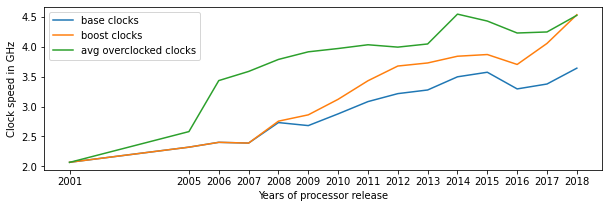

In [102]:
# Evolution of base clock in relation to boost clock, using the mean
base_clocks = []
boost_clocks = []
oc_clocks = []
for year in release_years:
  base_clocks.append(overclock_data[overclock_data['release'] == year]['base_clk'].mean())
  boost_clocks.append(overclock_data[overclock_data['release'] == year]['boost_clk'].mean())
  oc_clocks.append(overclock_data[overclock_data['release'] == year]['oc_clk'].mean())

plt.figure(figsize=(10,3))
plt.plot(release_years,base_clocks, label='base clocks')
plt.plot(release_years,boost_clocks, label='boost clocks')
plt.plot(release_years, oc_clocks, label='avg overclocked clocks')
plt.xticks(release_years)
plt.ylabel('Clock speed in GHz')
plt.xlabel('Years of processor release')
plt.legend()
plt.show()

# Result interpretation
This shows the trend towards more cores, which cannot sustain a high base clock due to the required power and therefore required cooling. But the graph shows at the same time, that the clock speeds for single or dual core loads continue to increase.

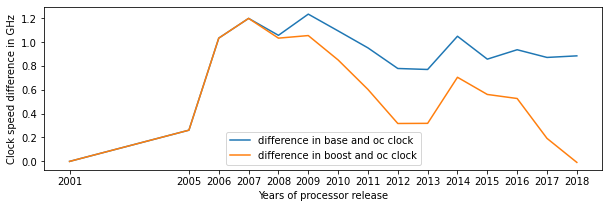

In [103]:
base_diff = []
boost_diff = []
for year in release_years:
  base_diff.append(overclock_data[overclock_data['release'] == year]['oc_diff'].mean())
  boost_diff.append(overclock_data[overclock_data['release'] == year]['oc_boost_diff'].mean())

plt.figure(figsize=(10,3))
plt.plot(release_years,base_diff, label='difference in base and oc clock')
plt.plot(release_years,boost_diff, label='difference in boost and oc clock')
plt.xticks(release_years)
plt.ylabel('Clock speed difference in GHz')
plt.xlabel('Years of processor release')
plt.legend()
plt.show()

# Result interpretation

The graph shows that, while the difference in base clock and oc clock are relatively stable, the difference between the maximum  boost clocks and the achieved overclocked results are very small.

This shows a trend in the development of CPUs, that the manufacturers are pushing for the highest possible clock speeds and therefore highest possible performance. Due to thermal or power limitations, these maximum clock speeds, are not used for loads of more than 2 cores. The overclocking results, therefore show that the advertised boost clock speeds can be achieved in an all core load and aren't the ceiling. The graph also shows, that the headroom for overclocking is already very slim on modern chips. 

Due to the overclocking dataset being during an all-core load and the CPU stat dataset showing maximum boost, which (most of the time) gives a frequency for at most 2 cores, it would also be feasable to conclude, that newer CPUs are difficult to overclock further than their advertised maximum boost clock.

Although the difference between boost and overclocked speeds seem to be very low, the workload for the overclocked results is for all cores, the CPU has access to. The advertised boost clocks, which the CPU stat dataset has is only applicable to at, most 2 cores. This means, although the results don't look like it, there is still overclocking done, because the frequency of all cores is different, than the advertised frequency for a load with the amount of cores.

In [104]:
# Calculate pearson correlation coefficient for all dataset points
only_clockspeeds = overclock_data.drop(["cpu", "cores", "threads", "oc_boost_diff", "oc_diff", "release", "oc_clk"], axis=1)

print(only_clockspeeds.corr(method="pearson"))

           base_clk  boost_clk
base_clk   1.000000   0.876945
boost_clk  0.876945   1.000000


The pearson correlation shows a strong correlation between the base and boost clock, meaning, that an in increase in the base clock leads to an increase in the boost clock.

-0.07111394915682036 143.70583769310244


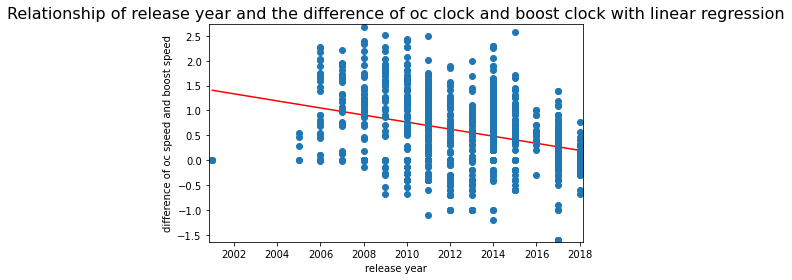

-0.014182360245876314 29.495535823179164


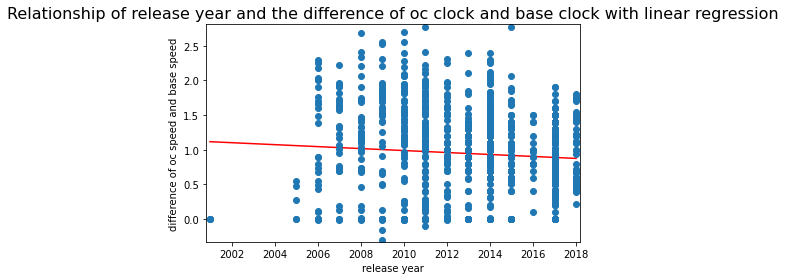

In [105]:
# Perform linear regression for oc_diff and oc_boost_diff with release year

def linear_regression(x,y):
  return np.polynomial.Polynomial.fit(x,y,1).convert().coef

# perform linear regression function
def perform_linear_regression(x,y,xlabel,ylabel,title):
  # Calculate the linear regression and output the slope and interception
  intercept, slope = linear_regression(x, y)
  print(slope, intercept)

  # Plot the data
  plt.plot(x, slope * x + intercept, color="red")
  plt.plot(x, y, marker='o', linestyle='none')
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title, fontsize=16)
  plt.tight_layout()
  plt.ticklabel_format(useOffset=False, style='plain')
  plt.margins(0.01)
  plt.show()


x = overclock_data["release"]
y = overclock_data["oc_diff"]
yboost = overclock_data["oc_boost_diff"]

perform_linear_regression(x, yboost, "release year", "difference of oc speed and boost speed", 'Relationship of release year and the difference of oc clock and boost clock with linear regression')

perform_linear_regression(x, y, "release year", "difference of oc speed and base speed", 'Relationship of release year and the difference of oc clock and base clock with linear regression')


leftMinimum 30.93515563261933 rightMinimum 30.935155632624014


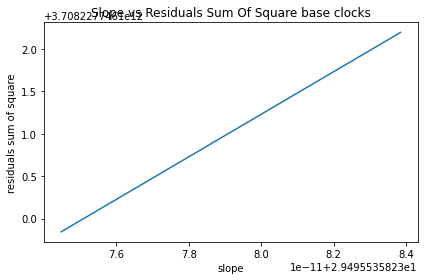

leftMinimum 150.71993882473308 rightMinimum 150.71993882473308


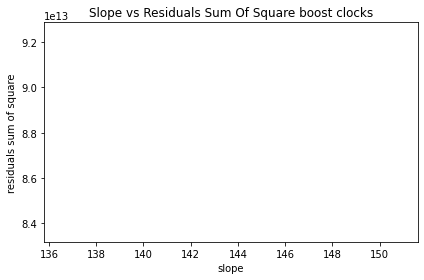

In [106]:
def test_with_rss(x, y, slope, intercept, title=""):

  def residualSumOfSquares(x, y, slope, intercept):
    return np.sum((y - (intercept + slope * x))**2)

  # Calculate the rss function value for the slope.
  slopeY = residualSumOfSquares(x, y, slope, intercept)


  def rssParabolaWithInvertedMimimum(i):
    # First: move the rss function on the y axis to zero and then 10 Percent of this way more into the negative direction.
    # Second: Mirror the negative part (minimum of the function) on the x axis in the positive direction.
    return abs(residualSumOfSquares(x, y, i, intercept) - slopeY * 1.1)


  def findMinimum(f, start):
    # Optimize the function using a given start point
    optimationResult = optimize.minimize(f, x0=start, method='Powell')

    # Check if the optimization was successful.
    if (not optimationResult.success):
      raise Exception(f'No minimum found for {f.__name__} with x0={start}')

    # Return the x value of the found minimum.
    return optimationResult.x[0]


  def findLeftAndRightMimima(f, start):
    # Get the left and right minimum.
    leftMinimum = findMinimum(f, start - 1)
    rightMinimum = findMinimum(f, start + 1)

    return (leftMinimum, rightMinimum)

  # Get the right and left minimum starting from the slope on the rss function with inverted minimum.
  leftMinimum, rightMinimum = findLeftAndRightMimima(rssParabolaWithInvertedMimimum, slope)

  print("leftMinimum", leftMinimum, "rightMinimum", rightMinimum)

  # Calculate the distance of both minima
  delta = abs(rightMinimum - leftMinimum)
  
  xStart = slope - delta
  xEnd = slope + delta
  # Get evenly spreaded points (the slope values) between the start and end point
  xValues = np.linspace(xStart, xEnd, 200)
  
  rssValues = np.empty_like(xValues)

  # Calculate the rss function values for the given slopes
  for i, slope_at_i in enumerate(xValues):
    rssValues[i] = residualSumOfSquares(x, y, slope_at_i, intercept)
  
  plt.plot(xValues, rssValues)
  plt.xlabel('slope')
  plt.ylabel('residuals sum of square')
  plt.title('Slope vs Residuals Sum Of Square ' + title)
  plt.tight_layout()
  plt.show()

# Perform rss test for oc_diff
slope, intercept = linear_regression(x,y)

test_with_rss(x, y, slope, intercept, title="base clocks")

# Perform rss test for oc_boost_diff
slope, intercept = linear_regression(x,yboost)

test_with_rss(x, yboost, slope, intercept, title="boost clocks")

The 95 percent confidence interval of the bootstraped base clock difference slopes is:  [-0.02724554 -0.00120972]


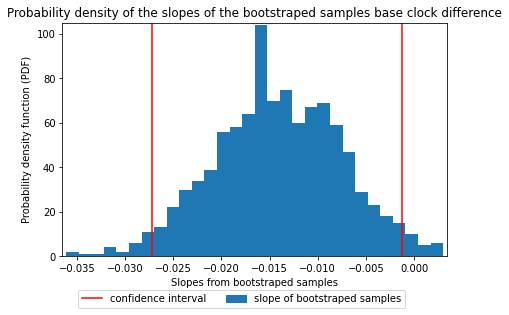

The 95 percent confidence interval of the bootstraped boost clock difference slopes is:  [-0.08521176 -0.05751047]


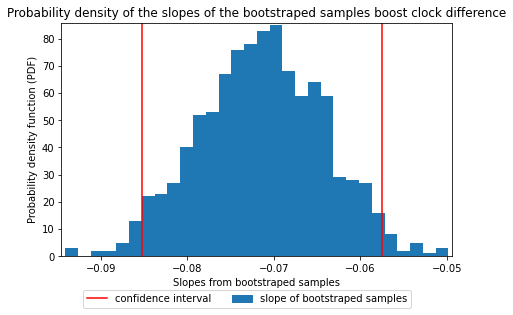

In [107]:
# pairs bootstrap or permutation

def perform_bootstrapping(x, y, title=""):

  def pairBootstrap(x, y, size=1, percentage=1):

    inds = np.arange(len(x))

    slopes = np.empty(size)
    intercepts = np.empty(size)

    # Generate replicates
    for i in range(size):
      indices = np.random.choice(inds, size=round(len(inds) * percentage))
      slopes[i], intercepts[i] = np.polyfit(x[indices], y[indices], 1)

    return slopes, intercepts


  def confidenceInterval(array, confidenceLevel=1):
    alphaValue = 1 - confidenceLevel
    
    halfAlphaValue = alphaValue / 2
    
    return np.percentile(array, [halfAlphaValue * 100, (1 - halfAlphaValue) * 100])


  bootstrapSize = 1000
  
  xValues = np.array([0, bootstrapSize])
  
  bootstrapSlopes, bootstrapIntercepts = pairBootstrap(x, y, bootstrapSize, 0.95)

  ci95 = confidenceInterval(bootstrapSlopes, 0.95)
  print('The 95 percent confidence interval of the bootstraped', title, 'slopes is: ', ci95)

  plt.hist(bootstrapSlopes, bins=30)
  plt.axvline(ci95[0], color='red')
  plt.axvline(ci95[1], color='red')

  legendHandles = [
    Line2D([0], [0], label='confidence interval', color='red'),
    patches.Patch(color='C0', label='slope of bootstraped samples')
  ]

  plt.gcf().legend(handles=legendHandles, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=len(legendHandles))
  plt.title('Probability density of the slopes of the bootstraped samples ' + title)
  plt.tight_layout()
  plt.ticklabel_format(useOffset=False, style='plain')
  plt.margins(0.01)
  plt.xlabel('Slopes from bootstraped samples')
  plt.ylabel('Probability density function (PDF)')
  plt.show()
  
  return (bootstrapSlopes, bootstrapIntercepts)

bootstrapSlopes, bootstrapIntercepts = perform_bootstrapping(x, y, "base clock difference")
bootstrapSlopes_boost, bootstrapIntercepts_boost = perform_bootstrapping(x, yboost, "boost clock difference")

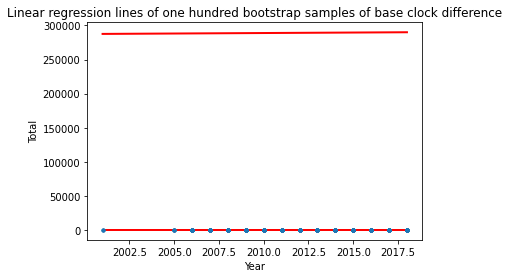

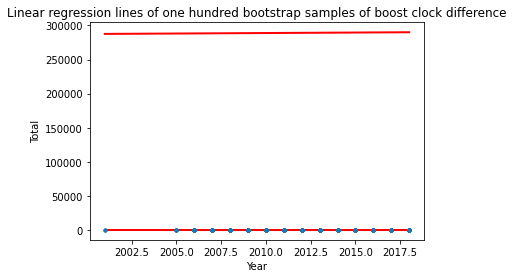

In [108]:
# Plot the first one hundred bootstrap lines
def plot_bootstrap_lines(x, y, bootstrapSlopes, bootstrapIntercepts, title=""):
  for i in range(100):
    plt.plot(x, bootstrapSlopes[i] * x + bootstrapIntercepts[i], linewidth=0.4, alpha=0.2, color='red')

  plt.plot(x, slope * x + intercept, linewidth=2, alpha=1, color='red')
  plt.plot(x, y, marker='.', linestyle='none')

  plt.xlabel('Year')
  plt.ylabel('Total')
  plt.title('Linear regression lines of one hundred bootstrap samples ' + title)
  plt.show()

plot_bootstrap_lines(x, y, bootstrapSlopes, bootstrapIntercepts, title="of base clock difference")

plot_bootstrap_lines(x, yboost, bootstrapSlopes_boost, bootstrapIntercepts_boost, title="of boost clock difference")

# Hypthesis
1. The amount of cores and the amount of threads coincide strongly
2. The overclock speeds strongly coincide with the boost clock
3. The newer the chip, the higher the achieved overclocked speeds
4. Over time the difference between overclock speeds and boost clock speeds will decrease, maybe below the boost clock, given new aggressive boosts behaviours.
5. The more cores a given CPU has, the lower its base clock speed is

In [109]:
# Calculate pearson correlation coefficient for all dataset points
only_clockspeeds = overclock_data.drop([], axis=1)

print(only_clockspeeds.corr(method="pearson"))


                  cores   threads  base_clk  boost_clk    oc_clk   release  \
cores          1.000000  0.948116  0.272317   0.522939  0.256077  0.596472   
threads        0.948116  1.000000  0.282662   0.522002  0.236978  0.589721   
base_clk       0.272317  0.282662  1.000000   0.876945  0.666701  0.578744   
boost_clk      0.522939  0.522002  0.876945   1.000000  0.592176  0.746569   
oc_clk         0.256077  0.236978  0.666701   0.592176  1.000000  0.310077   
release        0.596472  0.589721  0.578744   0.746569  0.310077  1.000000   
oc_diff        0.113425  0.079104  0.049804   0.053746  0.777604 -0.072714   
oc_boost_diff -0.183360 -0.205561 -0.020705  -0.226761  0.650536 -0.328864   

                oc_diff  oc_boost_diff  
cores          0.113425      -0.183360  
threads        0.079104      -0.205561  
base_clk       0.049804      -0.020705  
boost_clk      0.053746      -0.226761  
oc_clk         0.777604       0.650536  
release       -0.072714      -0.328864  
oc_diff   

In [110]:
# Calculate pearson correlation coefficient for all CPUs released in 2017 and later
only_clockspeeds = overclock_data.drop([], axis=1)

print(only_clockspeeds[only_clockspeeds["release"] >= 2017].corr(method="pearson"))

                  cores   threads  base_clk  boost_clk    oc_clk   release  \
cores          1.000000  0.955526 -0.202520   0.116247  0.014760  0.180771   
threads        0.955526  1.000000 -0.193856   0.102112 -0.002170  0.184223   
base_clk      -0.202520 -0.193856  1.000000   0.656915  0.786857  0.241287   
boost_clk      0.116247  0.102112  0.656915   1.000000  0.803467  0.428490   
oc_clk         0.014760 -0.002170  0.786857   0.803467  1.000000  0.163941   
release        0.180771  0.184223  0.241287   0.428490  0.163941  1.000000   
oc_diff        0.230415  0.194800  0.220945   0.598019  0.775736  0.012354   
oc_boost_diff -0.101087 -0.113507  0.577256   0.234906  0.767430 -0.193777   

                oc_diff  oc_boost_diff  
cores          0.230415      -0.101087  
threads        0.194800      -0.113507  
base_clk       0.220945       0.577256  
boost_clk      0.598019       0.234906  
oc_clk         0.775736       0.767430  
release        0.012354      -0.193777  
oc_diff   

# Hypothesis evaluation

Hypothesis 1: "The amount of cores and the amount of threads coincide strongly"<br>
  As shown above, the pearson correlation coefficient between the amount of threads and the amount of cores is 0.948116 and 0.955526 for CPUs released in 2017 and later. Therefore the amount of cores and the amount of threads are strongly correlated and the hypothesis can be considered **true**.

Hypothesis 2: "The overclock speeds strongly coincide with the boost clock"<br>
  Both pearson correlations above, respectively show a strong and very strong pearson correlation coefficient between the achieved overclock speeds and the advertised boost clock speeds, at 0.592176 for all CPUs and 0.803467 for CPUs released in 2017 and later. Interrestingly, the pearson correlation coefficient suggests a stronger correlation between the overclocked clock speeds and the base clock speeds, rather than the boost clock speeds, when looking at all chips. Due to the high coefficients, the hypothesis can be considered **true**.

Hypothesis 3: "The newer the chip, the higher the achieved overclocked speeds"<br>
  The pearson correlation coefficient for all CPUs in the dataset for this relation is 0.310077, which indicates a light correlation between the two. Considering this coefficient the hypothesis can be considered **true**. For newer CPUs, released in 2017 and onwards, the correlation coefficient is even smaller at 0.163941, indicating a decrease over time. The coefficient for CPUs released in 2017 and later, in contrast to all CPUs, is too low and the hypothesis _in this case_ can be considered **false**.

Hypothesis 4: "Over time the difference between overclock speeds and boost clock speeds will decrease, maybe below the boost clock, given new aggressive boosts behaviours."<br>
  Both pearson correlation coefficients have a negative value, -0.328864 for all CPUs and -0.193777 for CPUs released in 2017 and later.This indicates that the hypothesis can be considered **true** for all CPUs, the coefficient for CPUs released in 2017 and later can be considered **false**.

Hypothesis 5: "The more cores a given CPU has, the lower its base clock speed is"<br>
  The pearson correlation coefficient for all CPUs is 0.272317 and the hypothesis can, therefore, be considered **false**. In contrast to the coefficient for all CPUs, dating back to 2001, newer CPUs released in 2017 and later have a correlation coefficient of -0.202520 between the amount of cores and the base clock speed, suggesting that, for these CPUs, the hypothesis can be confirmed **true**.

A/B tests cannot be performed on this dataset

# What Is the Bonferroni Test?

The Bonferroni test is a type of multiple comparison test used in statistical analysis. When performing a hypothesis test with multiple comparisons, eventually a result could occur that appears to demonstrate statistical significance in the dependent variable, even when there is none.

If a particular test, such as a linear regression, thus yields correct results 99% of the time, running the same regression on 100 different samples could lead to at least one false-positive result at some point. The Bonferroni test attempts to prevent data from incorrectly appearing to be statistically significant like this by making an adjustment during comparison testing.
Key Takeaways

The Bonferroni test is a statistical test used to reduce the instance of a false positive.
In particular, Bonferroni designed an adjustment to prevent data from incorrectly appearing to be statistically significant.
An important limitation of Bonferroni correction is that it may lead analysts to mix actual true results.

Understanding the Bonferroni Test

The Bonferroni test, also known as "Bonferroni correction" or "Bonferroni adjustment" suggests that the p-value for each test must be equal to its alpha divided by the number of tests performed.

The Bonferroni test is a multiple-comparison correction used when several dependent or independent statistical tests are being performed simultaneously. The reason is that while a given alpha value may be appropriate for each individual comparison, it is not appropriate for the set of all comparisons. In order to eliminate multiple spurious positives, the alpha value needs to be lowered to account for the number of comparisons being performed.

The test is named for the Italian mathematician who developed it, Carlo Emilio Bonferroni (1892–1960).1 Other types of multiple comparison tests include Scheffé's test and the Tukey-Kramer method test. A criticism of the Bonferroni test is that it is too conservative and may fail to catch some significant findings.

In statistics, a null hypothesis is essentially the belief that there's no statistical difference between two data sets being compared. Hypothesis testing involves testing a statistical sample to confirm or reject a null hypothesis. The test is performed by taking a random sample of a population or group. While the null hypothesis is tested, the alternative hypothesis is also tested, whereby the two results are mutually exclusive. 

However, with any testing of a null hypothesis, there's the expectation that a false-positive result could occur. This is formally called a Type I error, and as a result, an error rate that reflects the likelihood of a Type I error is assigned to the test. In other words, a certain percentage of the results will likely yield a false positive.
Using Bonferroni Correction

For example, an error rate of 5% might typically be assigned to a statistical test, meaning that 5% of the time there will likely be a false positive. This 5% error rate is called the alpha level. However, when many comparisons are being made in an analysis, the error rate for each comparison can impact the other results, creating multiple false positives.

Bonferroni designed his method of correcting for the increased error rates in hypothesis testing that had multiple comparisons. Bonferroni's adjustment is calculated by taking the number of tests and dividing it into the alpha value. Using the 5% error rate from our example, two tests would yield an error rate of 0.025 or (.05/2) while four tests would therefore have an error rate of .0125 or (.05/4). Notice that the error rate decreases as the sample size increases. 